# Big Data Analysis Project - Data Exploratory Analysis

### This is a course project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
(Jianmo Ni, Larry Muhlstein, and Julian McAuley, “Modeling Heart Rate and Activity Data for Personalized Fitness Recommendation,” in The World Wide Web Conference on - WWW’19, San Francisco, CA, USA, 2019, pp. 1343–1353, doi: 10.1145/3308558.3313643.)
<br />
<br />
*The purpose of exploratory analysis is to have an insight of the data set and some initial visual inference, as well as looking for missing data & data imbalance.*

### A. Initialize pyspark framework and load data into pyspark's dataframe
Import necessary modules/ libraries for use later and load the data set into spark dataframe:<br />
   *(Note: the raw data and metadata files are download from the source above, unzipped and put into 'data' folder)*

In [1]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR.json'
#filename_metadata = './data/endomondoMeta.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")

# Load meta data file into pyspark data frame as well
#df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))


Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### B. Let's have an overview of the raw data set
#### 1) Columns & types of the data set:
   *The data set has both single value columns (int, string) and column made of arrays/list.*

In [2]:
print('Columns & datatypes:')
DataFrame(df.dtypes, columns =['Column Name','Data type'])


Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


#### 2) Data set description and display the first 2 rows:
*Note: The describe function auto exlcuded the columns with list/ array type.<br />Based on the column type, data frame description and the first 2 rows, we know that each data row is a record of a workout of a single user, with the associated activity type (<em>sport</em>) and orther data like heart rates, locations and record times (<em>timestamp</em>).*

In [3]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421



Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


#### 3) Summarize on users count and genders, and also total activities (workouts) taken by each gender:
   *A notice is that there were some activities without clear info about gender (recorded as '<em>unknown</em>').*

In [4]:
print('Summarize on genders:')
gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
gender_activities_count = df.groupBy('gender').count().toPandas()
gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                    , how='inner', lsuffix='_gu')
gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
gender_user_activity_count

Summarize on genders:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1942
1,female,110,15959
2,male,979,235119


#### 4) Summarize on activities (how many activities and gender distribution by activities):
  *It can be observed that there are 49 total kind of sports (activity types) in this dataset, most of the recorded workouts happened on a few common sports only like run, walk, biking, etc..<br />
  Moreover, in addition to summary tables, we can have look at some plots from now to have a more visualized feel.*

In [5]:
%matplotlib inline

Activity count:


,Sport (Activity) types
0,49



List of all activities:


sport  count                
gender                          female    male unknown
0                      aerobics      3      43       0
1                     badminton      0      17       0
2                    basketball      0      14       0
3              beach volleyball      0       2       0
4                          bike   4172   92966     863
5              bike (transport)    414   10030       1
6              circuit training     22     196       0
7                      climbing      1       5       0
8       core stability training    143    1103      16
9          cross-country skiing    194     755       0
10                      dancing      0       0       1
11              downhill skiing      2     142       0
12                   elliptical     38      45       0
13              fitness walking    173     228       1
14                         golf      0      12       0
15                   gymnastics      4     157       1
16                       hiking     71     286       0
17             horseback riding      8       8       0
18               indoor cycling    148    2444      14
19                     kayaking      2     253       0
20                 kite surfing      0       1       0
21                 martial arts      0       5       0
22                mountain bike    353   12782     375
23                 orienteering     70    1127       0
24                      pilates      2       5       0
25                roller skiing      6     402       0
26                       rowing     39      88       0
27                        rugby      0       7       0
28                          run   9360  107882     660
29                      sailing      0       2       0
30                 scuba diving      0       1       0
31                        skate     42     470       0
32                skateboarding      0       1       0
33                 snowboarding      0       5       0
34                  snowshoeing      8      24       0
35                       soccer      1      70       0
36                       squash      0       1       0
37                stair climing      7       6       0
38                 step counter      0       2       0
39                     swimming      4      29       8
40                 table tennis      0       5       0
41                       tennis      0       8       0
42            treadmill running     14      56       0
43            treadmill walking      0       2       0
44                         walk    626    3204       1
45              weight training     19     217       1
46                   wheelchair      0       1       0
47                  windsurfing      0       1       0
48                         yoga     13       9       0


Summarized activity participation by percentage of gender (Double click on image to view larger version):


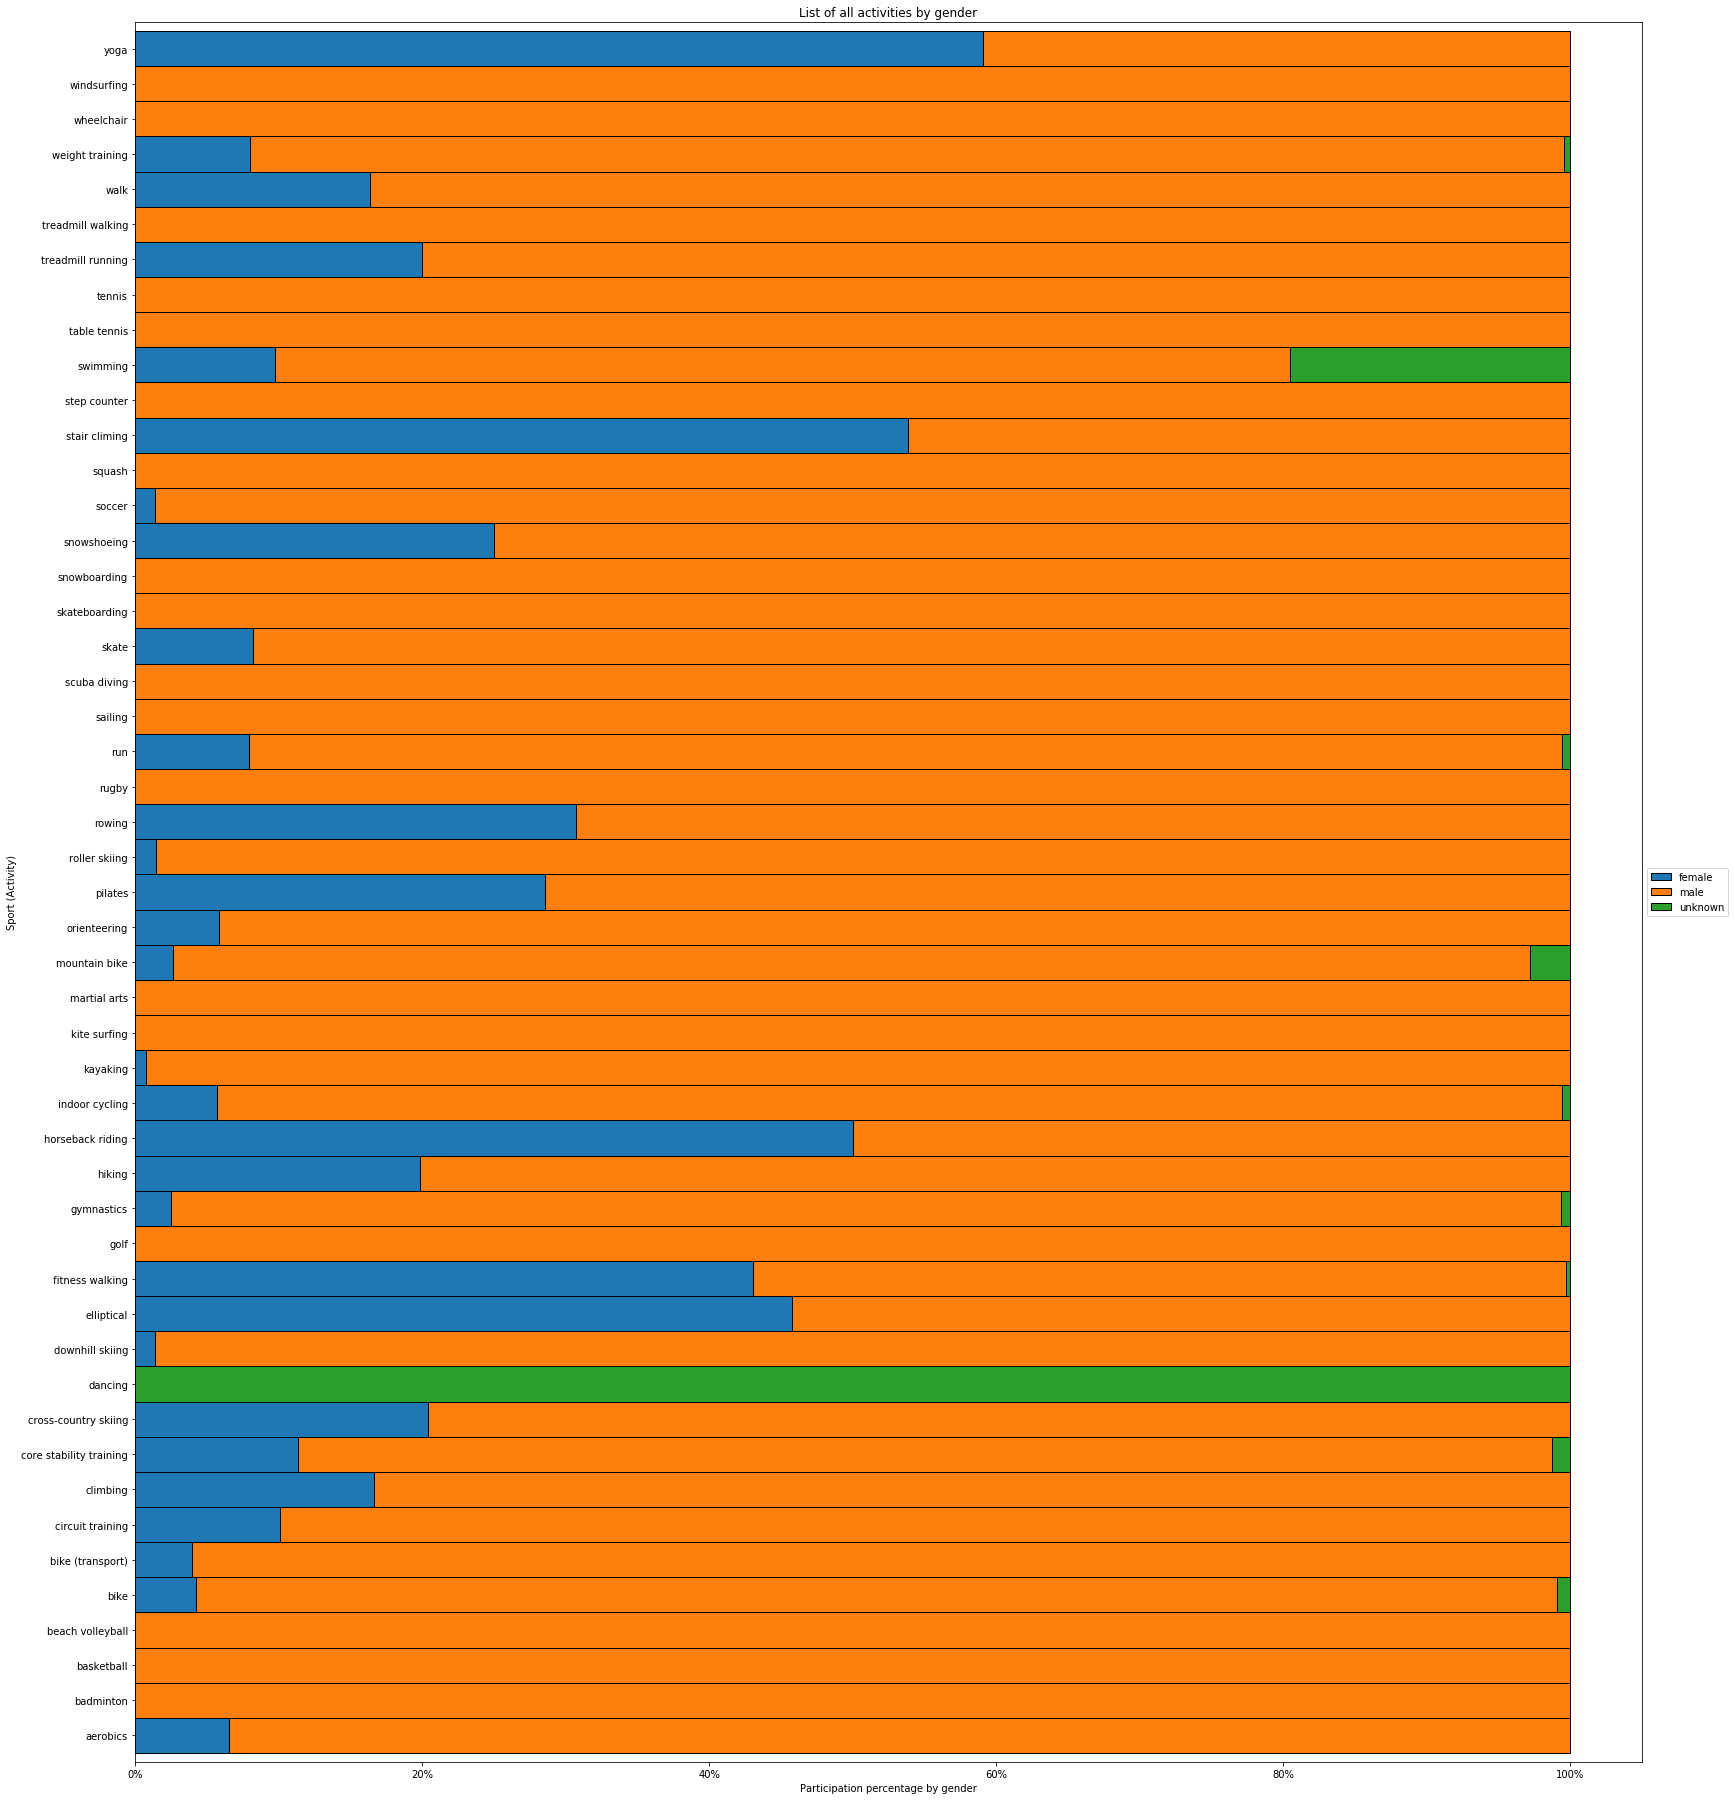

In [6]:

#userCount = df.select('userId').distinct().count()
activities = df.select('sport').distinct()
activityCount = activities.count()
#TO DO: average workouts by user
count = DataFrame([[activityCount]] ,columns= ['Sport (Activity) types'])
print('Activity count:')
count
print('\nList of all activities:')
#activities.toPandas()
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
activities_by_gender_sum = activities_by_gender.set_index(['sport','gender']).unstack(level='gender', fill_value=0).reset_index()
#activities_by_gender_sum = activities_by_gender_sum.astype(int)
activities_by_gender_sum
print('\nSummarized activity participation by percentage of gender (Double click on image to view larger version):')
fig = plt.figure(figsize=(27, 32))
grid_size = (1,1);

ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)


# source1: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot#stacked-bar-plot-with-group-by
# source2: https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1
                , edgecolor='black', ax=ax, title='List of all activities by gender');
a = plt.ylabel('Sport (Activity)');
b = plt.xlabel('Participation percentage by gender');
c = plt.legend(sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5));
d = plt.rcParams.update({'font.size': 26});
#plt.axes.xaxis.labelpad = 10
ax = plt.gca()
e = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
plt.show()

#### 5) Next, we will look further into each datarow and observe how many data points were record per activities
*For a more detailed observation, we break down the record count per activity into each individual sport. <br />
Based on the distribution, the maximum records per workout is 500, but not all workouts and sport type reach that number.*

New PerWorkoutRecordCount column:

Plot of workouts distribution by activity type (Double click on image to view larger version):


C:\Anaconda2\envs\bigdata-lab\lib\site-packages\pandas\plotting\_core.py:2396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


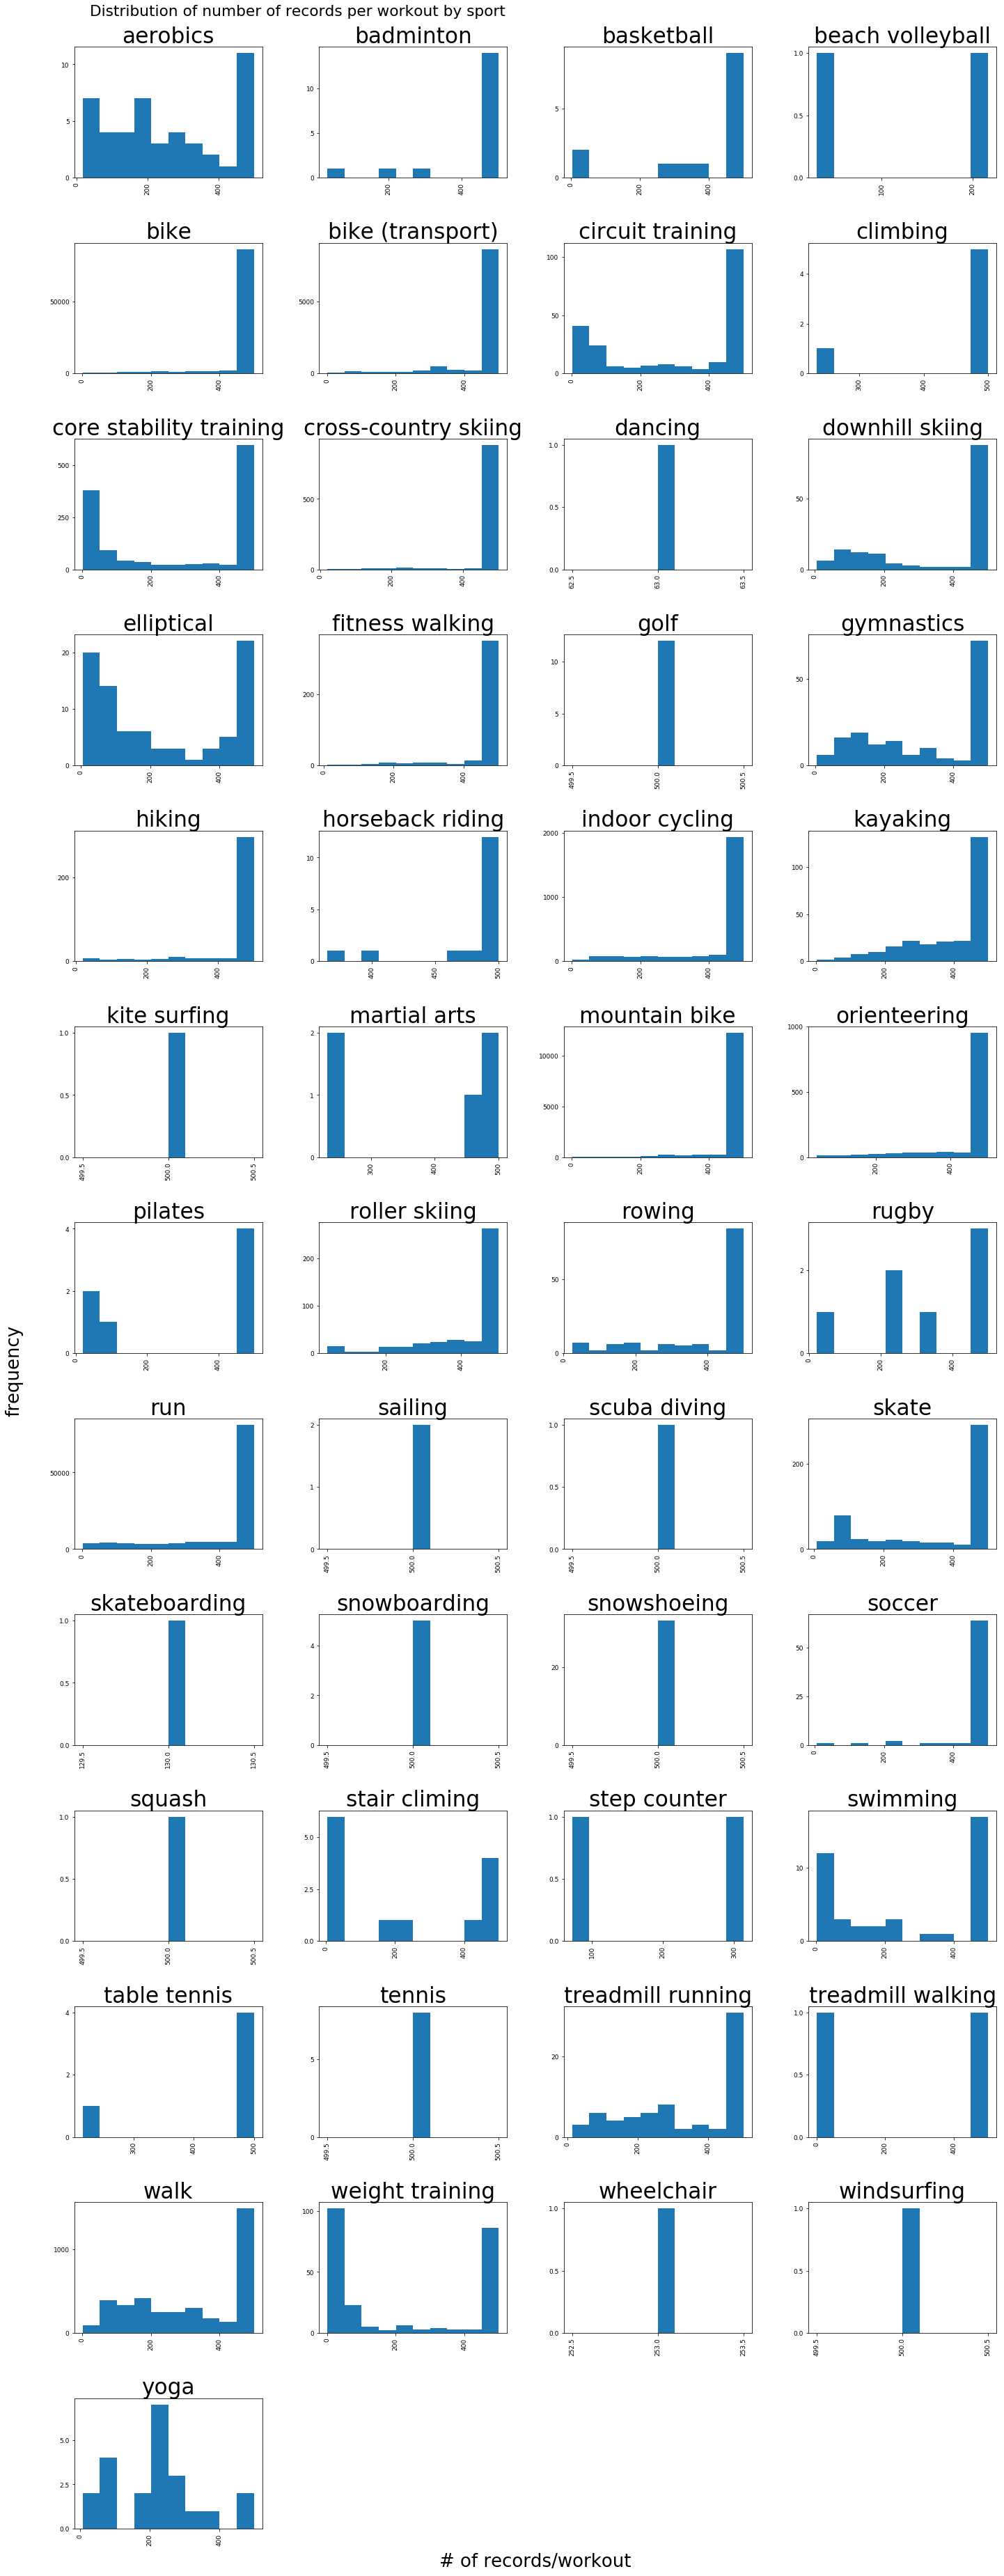

In [7]:
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))
print('New PerWorkoutRecordCount column:')
df.select('userId','id','sport','timestamp','PerWorkoutRecordCount').limit(5).toPandas()

print('\nPlot of workouts distribution by activity type (Double click on image to view larger version):')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
fig = plt.figure(figsize=(figsize_x, figsize_y)) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)


PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True, xlabelsize=9, ylabelsize=9, by='sport', ax = ax,
    layout = (13, 4), figsize=(4,6)
    )

fig.text(1, 1.6, 'Distribution of number of records per workout by sport', ha='center', 
         fontsize='small', transform=ax.transAxes);
fig.text(0.5, 0.14, '# of records/workout', va='center', ha='center', transform=fig.transFigure);
fig.text(0.04, 0.5, 'frequency', va='center', rotation='vertical');




#### 6) Now, we can look at the duration of each workout (in minutes).
  *In order to do that, first,  we create a new column to change the raw timestamp values into python datetime format, then get the difference between max and min of the list of datetime of each workout.* <br />


In [8]:
from datetime import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

# Support function to convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    #date_time_list = [datetime.fromtimestamp(t) for t in timestamp_list]
    return [datetime.fromtimestamp(t) for t in timestamp_list]

# Register the support function 'to_time' as a user defined function into pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())


# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

print('New columns (date_time & duration in minutes):')
df.select('timestamp','date_time','duration').limit(5).toPandas()

print('\nLet''s look at the statistics of the new duration column:')
df.describe(['duration']).toPandas()

New columns (date_time & duration in minutes):


,timestamp,date_time,duration
0,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 12:45:46, 2014-08-24 12:45:54, 201...",126.483330
1,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 16:41:22, 2014-08-16 16:41:27, 201...",74.000000
2,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 11:47:39, 2014-08-12 11:47:46, 201...",112.483330
3,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 13:20:42, 2014-08-07 13:20:48, 201...",75.316666
4,"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 12:10:34, 2014-08-01 12:10:36, 201...",22.616667



Lets look at the statistics of the new duration column:


,summary,duration
0,count,253020
1,mean,84.4812335583769
2,stddev,98.04698679884521
3,min,0.0
4,max,1439.9667


Now it's plot time for duration.<br />
*From the duration data & distribution plot, it can be seen that workout duration can last from 0 minute and up to 1 full day (1440 minutes = 24 hours). Majority of the activities happens in 1-2 hours, only a few sports with a few cases each type happened in longer durations, such as moutain bike, hiking, sailing, etc..*


Plot of distribution of duration per sport type (Double click on image to view larger version):


C:\Anaconda2\envs\bigdata-lab\lib\site-packages\pandas\plotting\_core.py:2396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


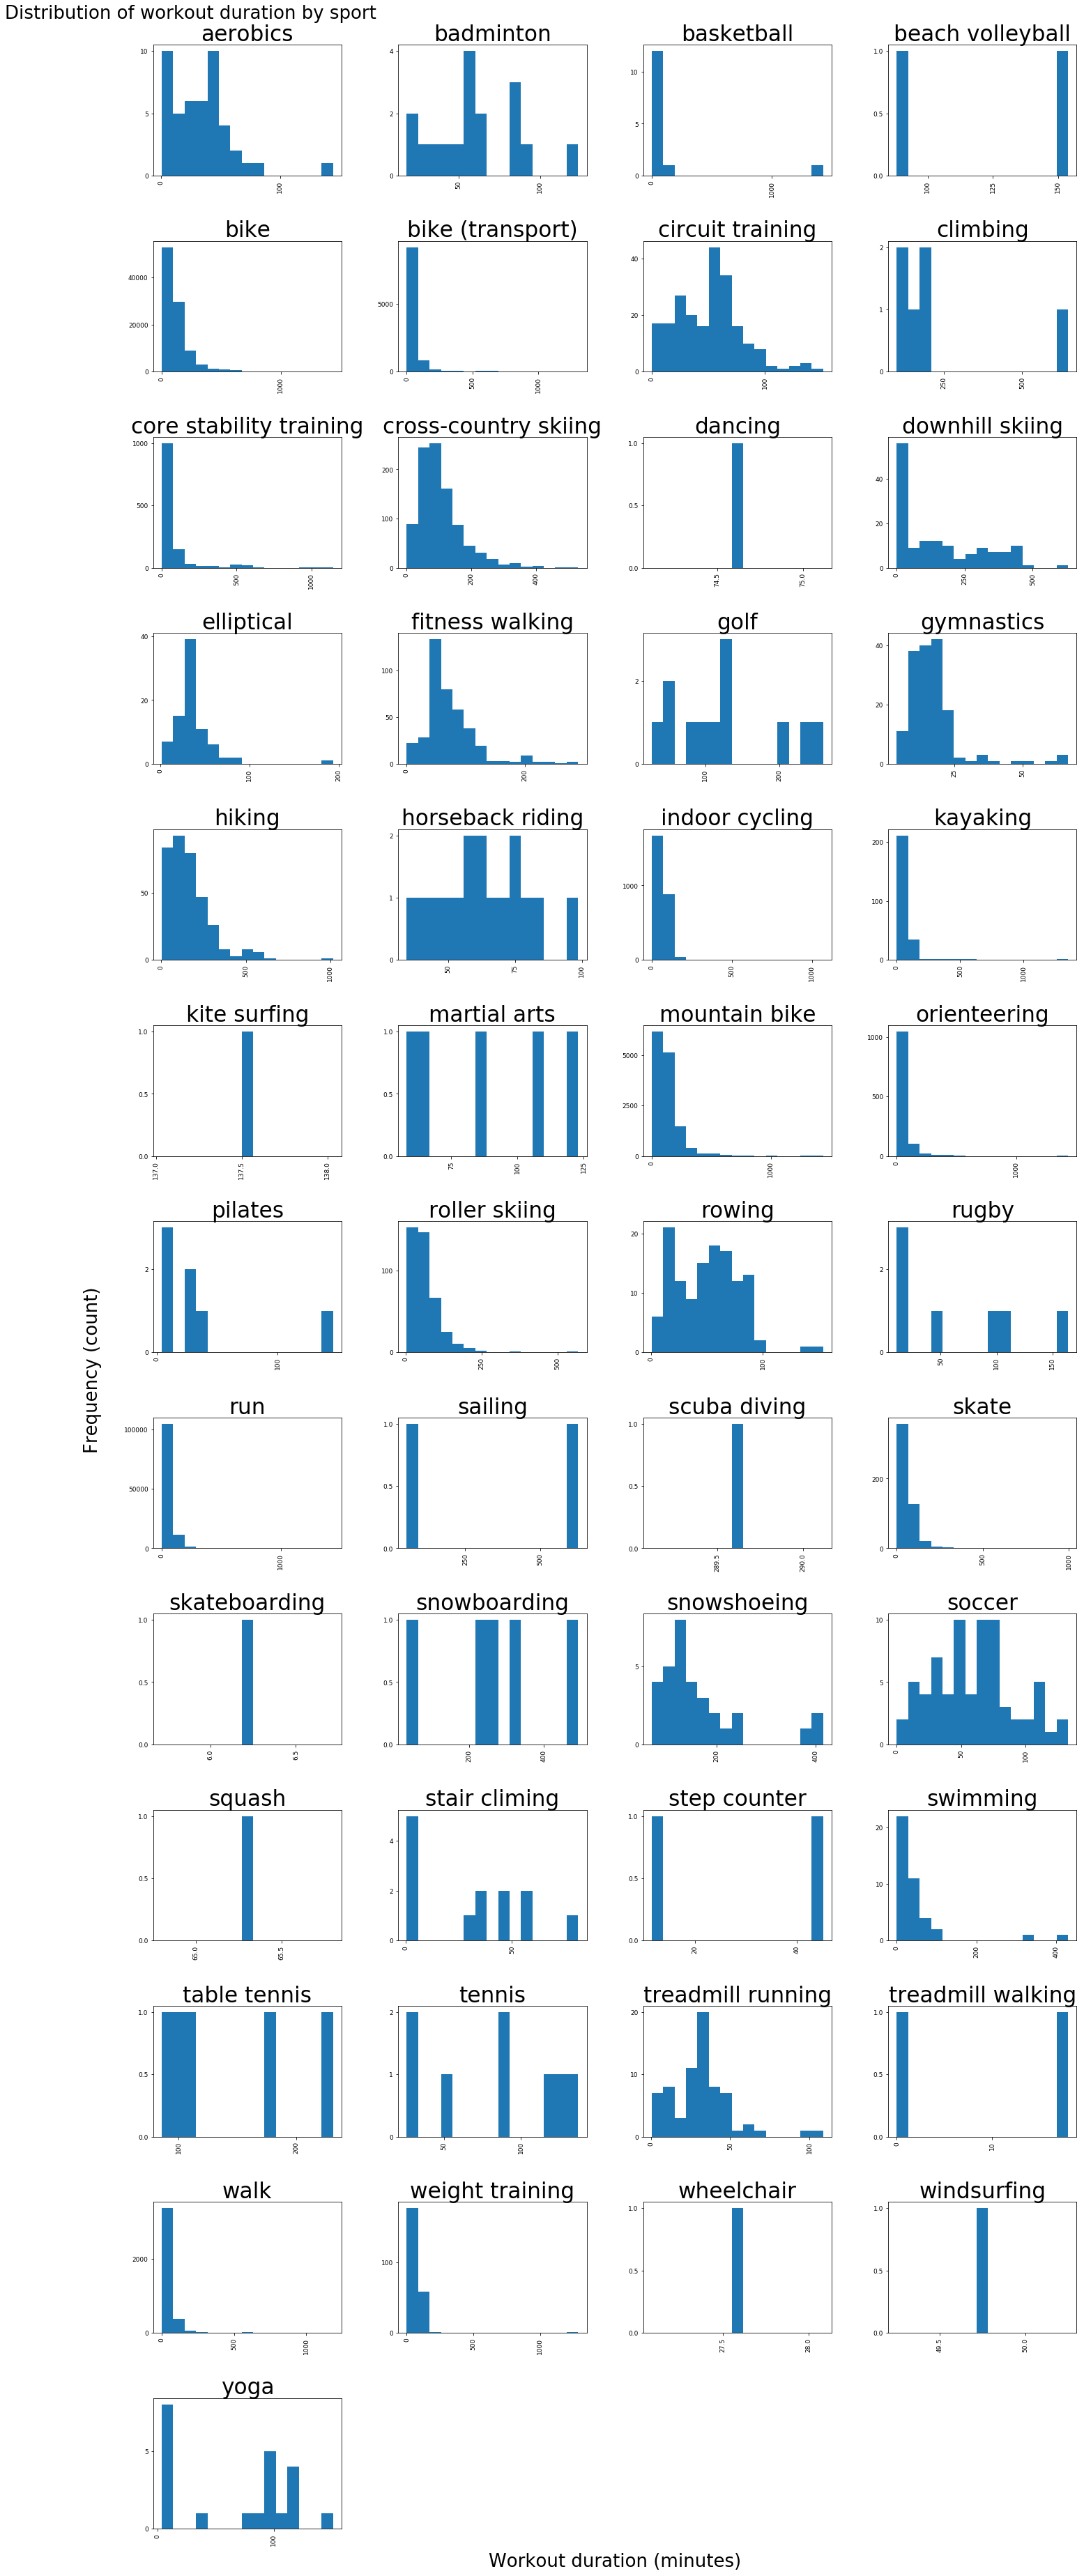

In [9]:

print('\nPlot of distribution of duration per sport type (Double click on image to view larger version):')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
fig = plt.figure(figsize=(figsize_x, figsize_y)) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', bins=15, sharex = False, grid=True, xlabelsize=9, ylabelsize=9, by='sport', ax = ax,
    layout = (13, 4), figsize=(plot_size_x,plot_size_y)
    )

z = fig.text(1, 1.6, 'Distribution of workout duration by sport', ha='right', va='center', transform=ax.transAxes)
y = fig.text(0.5, 0.14, 'Workout duration (minutes)', ha='center', va='center', transform=fig.transFigure)
z =fig.text(0.04, 0.5, 'Frequency (count)', va='center', rotation='vertical')

#### 7) Next, we will have a first look at the heart rate for each workout. 
*Due to the huge amount of users and workout numbers, we just picked randomly up to a x number of users per gender (ex, 5), and up to y workouts per activity type (ex, 10).<br />
Based on the plot, we can see that the raw data is quite messy, even a few workouts have heart rate records of 0 (!!!). So we know that there must be some data cleaning job to be done.*

In [10]:
# Use 2 variable to determine the sampling criteria: maximum users per gender and maximum workouts per sport
max_users_per_gender, max_workouts_per_sport = 20, 15

# Get unique list of userId and gender, for sampling purpose
users_genders = df.select('userId', 'gender').distinct().toPandas()
# Use 'sample' function to pick up to 3 userId per gender from the unique userId list
random_x_users_per_gender = users_genders.groupby('gender')['userId'].apply(
            lambda s: s.sample(min(len(s), max_users_per_gender))
)

# Apply filter on the main pyspark dataframe for sampling
samples_by_gender = df.where(df.userId.isin(list(random_x_users_per_gender)))

# Next, generate the unique activity ids and sport types list from the sampled data set 
workout_sports = samples_by_gender.select('id', 'sport').distinct().toPandas()
# Use 'sample' function to pick up to 10 activity ids for each kind of sport 
random_y_workouts_per_sport = workout_sports.groupby('sport')['id'].apply(
    lambda s: s.sample(min(len(s), max_workouts_per_sport))
)

# Apply filter to the sampled dataset to continue reduce the number of workouts per activity type
samples_by_gender_and_sport = samples_by_gender.where(df.id.isin(list(random_y_workouts_per_sport)))

# Collect the sampled data set to Pandas to be used with plot features
pd_df = samples_by_gender_and_sport.toPandas()
print('\nSampled data overview:')
pd_df.describe()


Sampled data overview:


,id,userId,PerWorkoutRecordCount,duration
count,1.920000e+02,1.920000e+02,192.000000,192.000000
mean,3.525010e+08,5.280916e+06,424.947917,92.379173
std,1.313916e+08,3.307308e+06,139.937748,117.219955
min,4.057186e+07,1.261140e+05,2.000000,0.016667
25%,2.895557e+08,2.692363e+06,414.500000,34.591667
50%,3.371049e+08,5.210077e+06,500.000000,56.516666
75%,4.471393e+08,7.801809e+06,500.000000,95.233332
max,6.408774e+08,1.401894e+07,500.000000,1015.983337


All sampling have been done, let's plot heart rate on the sample data set! <br />
*Note: from this first look, the heart rate and workout time of a day is quite varied per user and activity. We convert the datetime to time value to use for the plot*

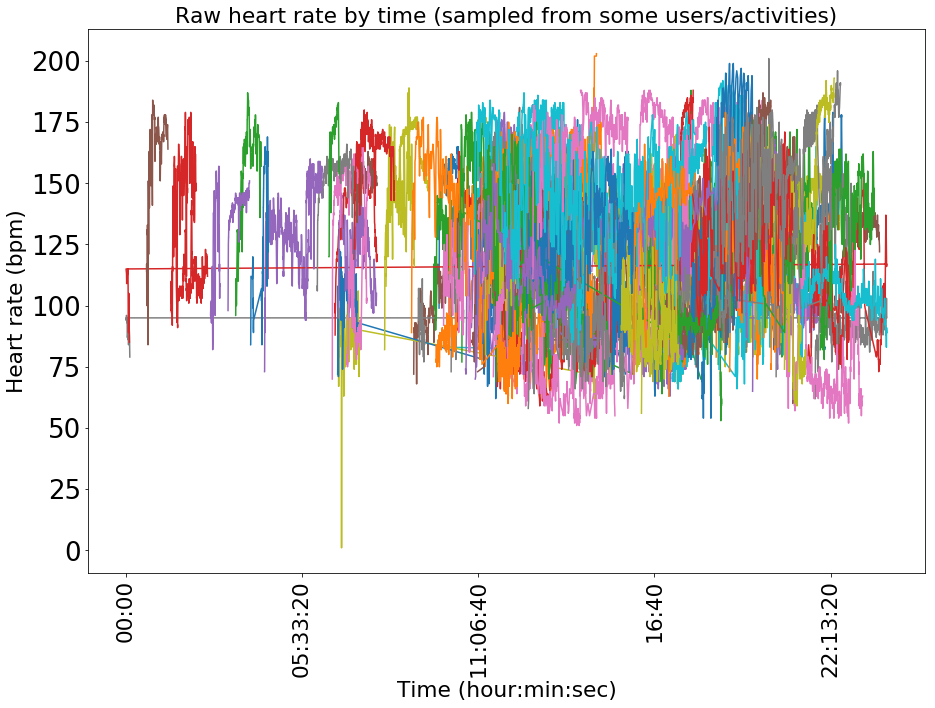

In [11]:
fig = plt.figure(figsize=(15, 10))
pd_df_temp = pd_df
for index,data_row in pd_df_temp.iterrows():
    data_row['date_time'] = [date_time.time() for date_time in data_row['date_time']]
    label = 'user: ' + str(data_row['userId']) + ' - sport: ' + data_row['sport']
    a= plt.plot(data_row['date_time'], data_row['heart_rate'], label=label)

a = plt.title('Raw heart rate by time (sampled from some users/activities)',fontsize='small')
b = plt.xticks(rotation='vertical', fontsize='small')
#c = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 8})
a= plt.ylabel('Heart rate (bpm)', fontsize='small')
b= plt.xlabel('Time (hour:min:sec)', fontsize='small')


#### 8) Continue looking on a normalized timestamp

New normalized datetime:


,userId,date_time,normalized_date_time
0,897592,"[2014-04-13 12:34:26, 2014-04-13 12:34:27, 201...","[0, 1, 5, 10, 12, 15, 24, 34, 40, 52, 73, 167,..."
1,2868369,"[2014-11-04 19:55:00, 2014-11-04 19:55:04, 201...","[0, 4, 8, 13, 17, 21, 26, 30, 35, 39, 43, 48, ..."
2,9613679,"[2013-04-29 20:30:42, 2013-04-29 20:30:44, 201...","[0, 2, 5, 12, 22, 31, 40, 43, 53, 62, 72, 78, ..."
3,9613679,"[2013-04-03 19:03:58, 2013-04-03 19:04:01]","[0, 3]"
4,9613679,"[2013-04-03 19:03:20, 2013-04-03 19:03:21]","[0, 1]"



Plot raw heart rate (sampled) by normalized time:


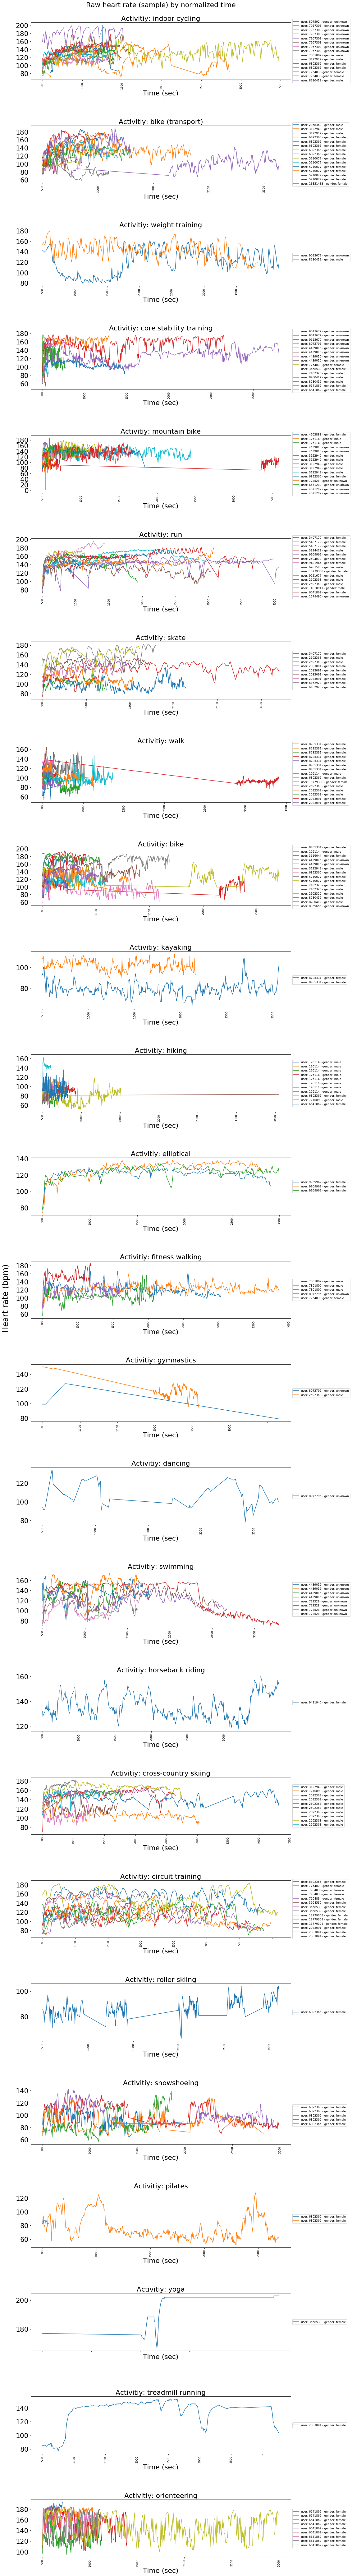

In [12]:

#def calculate_normalized_datetime(row):
#    min_datetime = row['date_time']
#    return [date_time - min_datetime for date_time in row.date_time]

flattern = lambda l: set([item for sublist in l for item in sublist])

normalized_datetime_list = []
for index,data_row in pd_df.iterrows():
    min_date_time = min(data_row['date_time'])
    normalized_datetime_list.append([(date_time - min_date_time).seconds for date_time in data_row['date_time']])

pd_df['normalized_date_time'] = normalized_datetime_list

print('New normalized datetime:')
pd_df.head(5)[['userId','date_time','normalized_date_time']]

print('\nPlot raw heart rate (sampled) by normalized time:')

sport_list = pd_df['sport'].unique()
fig, axs = plt.subplots(len(sport_list), figsize=(15, 6*len(sport_list)))
a = fig.subplots_adjust(hspace = 0.8)
c = plt.setp(axs, yticks=range(0,250,20))

for sport_index, sport in enumerate(sport_list):
    workout = pd_df[pd_df.sport == sport]
    max_time = max(flattern(workout.normalized_date_time))
    for workout_index, data_row in workout.iterrows():
        label = 'user: ' + str(data_row['userId']) + ' - gender: ' + data_row['gender']
        a= axs[sport_index].plot(data_row['normalized_date_time'], data_row['heart_rate'], label=label)
    b= axs[sport_index].set_title('Activitiy: ' + sport, fontsize='small')
    b= axs[sport_index].set_xlabel('Time (sec)', fontsize='small')
    a = axs[sport_index].set_xticklabels(range(0, max_time, 500),rotation = 'vertical', fontsize=9)
    b = axs[sport_index].set_yticklabels(range(0,250,20),fontsize='small')
    c = axs[sport_index].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 9})
#a= plt.ylabel('Heart rate (bpm)')
z =fig.text(0.04, 0.5, 'Heart rate (bpm)', va='center', rotation='vertical')
z =fig.text(0.5, 1.3, 'Raw heart rate (sample) by normalized time', 
            ha='center', va='center', fontsize='small', transform=axs[0].transAxes)
#a = plt.suptitle('Raw heart rate (sample) by normalized time',fontsize='small')